# Types

Generate a net that can identify a pokemon's type based on its artwork.

## Download dataset from kaggle

In [1]:
from pathlib import Path
import pandas as pd
import pokeml.data.fetch_data as poke_data

# Specify where we will save the dataset
dataset_loc = Path("../data/types/")

# Download Kaggle dataset to that location
poke_data.download_kaggle_dataset(
    "vishalsubbiah/pokemon-images-and-types",
    dataset_loc,
)

## Dataset
Generate a Dataset of TypesDataset from the downloaded dataset.  
Apply required transforms to the inputs.

In [2]:
from pokeml.data import TypesDataset
from torchvision.transforms import Compose, ToTensor, RandomRotation


def get_input_transforms(train):
    input_tfms = [
        ToTensor(),
    ]
    if train:
        input_tfms.append(RandomRotation(180))

    return Compose(input_tfms)


usetypes = ["Fire", "Water", "Grass"]

data = TypesDataset(dataset_loc.resolve(), input_tfms=get_input_transforms(train=True))

Plot a few inputs to see what we're dealing with.

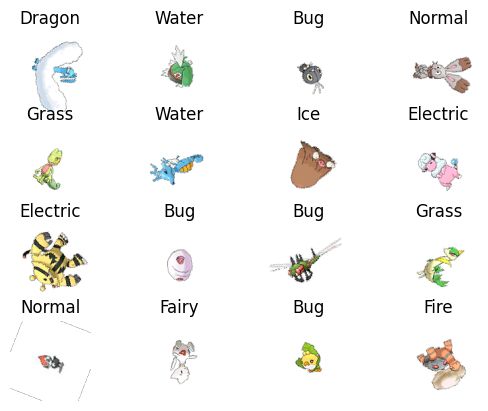

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(4, 4)

for i, axis in enumerate(ax.ravel()):
    axis.imshow(np.array(data[i][0].permute(1, 2, 0)))
    axis.set_title(data[i][1])
    axis.axis("off")

Transform the targets to a one-hot vector.  
Create a training and validation set.

In [4]:
from torch import tensor, eye

target_names = sorted(data.dataset["Type1"].unique())

print(f"There are {len(target_names)} different Pokemon types in this dataset.")
print(f"Pokemon types in this dataset are:{[x for x in target_names]}")

target_tfms = Compose([lambda x: eye(len(target_names))[target_names.index(x)]])

train_set = TypesDataset(
    dataset_loc.resolve(),
    input_tfms=get_input_transforms(train=True),
    target_tfms=target_tfms,
    train=True,
    typelist=usetypes,
)
valid_set = TypesDataset(
    dataset_loc.resolve(),
    input_tfms=get_input_transforms(train=False),
    target_tfms=target_tfms,
    train=False,
    typelist=usetypes,
)

# for _, (input_feats, target) in zip(range(5), train_set):
#     print(input_feats, target)

There are 18 different Pokemon types in this dataset.
Pokemon types in this dataset are:['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']


## DataLoader
Put the datasets into dataloaders.

In [16]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
)

# for batch, tar in valid_loader:
#     print(batch, tar)

## Net

In [17]:
from torchvision.models import mobilenet_v3_small
from torchvision.models import MobileNet_V3_Small_Weights
from torch.nn import Linear, Conv2d

model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

# Extend to accept 4 input channels in the image
model.features[0][0] = Conv2d(
    4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
)

model.classifier[3] = Linear(model.classifier[3].in_features, len(target_names))

Loss function and optimiser.

In [18]:
from torch.nn import BCELoss
from torch.optim import Adam

loss_func = BCELoss()
optimiser = Adam(model.parameters(), lr=1e-3)

## Set the device

In [19]:
from torch.cuda import is_available
from torch.backends import mps

if is_available():
    DEVICE = "cuda"
elif mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# Note: here the return/assignment to ``_`` is just to suppress the print.
# The model is moved onto the correct device in-place.
_ = model.to(DEVICE)

Using device: mps


## 

In [20]:
from torch import no_grad
from torcheval.metrics.aggregation.auc import AUC


def batch_accuracy(preds, tars):
    return (preds.argmax(dim=1) == tars.argmax(dim=1)).float().mean().item()


def train_one_epoch(
    model,
    train_loader,
    optimiser,
    loss_func,
    AUC_metric,
):
    # Put model in train mode
    model.train()

    metrics: Dict[str, float] = {"loss": [], "accuracy": [], "AUC": []}

    # move things to device
    for batch, targets in train_loader:
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        # Set optimiser gradients to zero
        optimiser.zero_grad()
        predictions = model(batch).softmax(dim=1)

        loss = loss_func(predictions, targets)

        loss.backward()
        optimiser.step()

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_accuracy(predictions, targets))
        AUC_metric.reset()
        AUC_metric.update(predictions, targets)
        metrics["AUC"].append(AUC_metric.compute().float().mean().item())

    return {key: mean(val) for key, val in metrics.items()}


@no_grad()
def validate_one_epoch(
    model,
    valid_loader,
    loss_func,
    AUC_metric,
):
    # Put model in train mode
    model.eval()

    metrics: Dict[str, float] = {"loss": [], "accuracy": [], "AUC": []}

    # move things to device
    for batch, targets in train_loader:
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        predictions = model(batch).softmax(dim=1)

        loss = loss_func(predictions, targets)

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_accuracy(predictions, targets))
        AUC_metric.reset()
        AUC_metric.update(predictions, targets)
        metrics["AUC"].append(AUC_metric.compute().float().mean().item())

    return {key: mean(val) for key, val in metrics.items()}

## Run training Loop

In [22]:
from time import perf_counter
from numpy import mean
from pandas import DataFrame

epochs = 90

train_metrics, valid_metrics = [], []
AUC_metric = AUC(n_tasks=16)
#
for epoch in range(epochs):
    start_time = perf_counter()

    train_metrics.append(
        train_one_epoch(model, train_loader, optimiser, loss_func, AUC_metric)
    )

    valid_metrics.append(validate_one_epoch(model, valid_loader, loss_func, AUC_metric))

    stop_time = perf_counter()

    print(
        f"Epoch {epoch} time: {stop_time - start_time:.3f} seconds. Accuracy: {valid_metrics[-1]['accuracy']} AUC: {valid_metrics[-1]['AUC']}"
    )

print("\n")

train_metrics = DataFrame(train_metrics)
valid_metrics = DataFrame(valid_metrics)

metrics = train_metrics.join(valid_metrics, lsuffix="_train", rsuffix="_valid")

print(metrics)

Epoch 0 time: 2.148 seconds. Accuracy: 0.3072916666666667 AUC: 0.1546661127358675
Epoch 1 time: 2.024 seconds. Accuracy: 0.3072916666666667 AUC: 0.13423520823319754
Epoch 2 time: 1.947 seconds. Accuracy: 0.4947916666666667 AUC: 0.06253786819676559
Epoch 3 time: 2.013 seconds. Accuracy: 0.3020833333333333 AUC: 0.05907165569563707
Epoch 4 time: 2.028 seconds. Accuracy: 0.2604166666666667 AUC: 0.015694566847135622
Epoch 5 time: 2.041 seconds. Accuracy: 0.3229166666666667 AUC: 0.012246563797816634
Epoch 6 time: 2.004 seconds. Accuracy: 0.4166666666666667 AUC: 0.08704864668349425
Epoch 7 time: 2.043 seconds. Accuracy: 0.4895833333333333 AUC: 0.08374551745752494
Epoch 8 time: 2.156 seconds. Accuracy: 0.3333333333333333 AUC: 0.07115673708419006
Epoch 9 time: 2.066 seconds. Accuracy: 0.3072916666666667 AUC: 0.10316827706992626
Epoch 10 time: 2.022 seconds. Accuracy: 0.3020833333333333 AUC: 0.0740924309939146
Epoch 11 time: 2.124 seconds. Accuracy: 0.3125 AUC: 0.05738483555614948
Epoch 12 time:

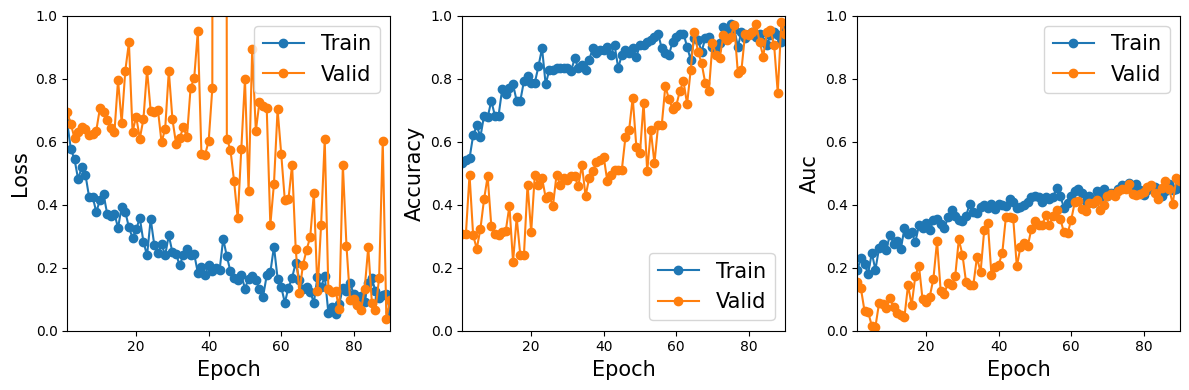

In [23]:
import matplotlib.pyplot as plt
from numpy import linspace


quantities = ["loss", "accuracy", "AUC"]
splits = ["train", "valid"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for axis, quant in zip(axes.ravel(), quantities):
    for split in splits:
        key = f"{quant}_{split}"
        axis.plot(
            linspace(1, epochs, epochs),
            metrics[key],
            "-o",
            label=split.capitalize(),
        )
    axis.set_ylabel(quant.capitalize(), fontsize=15)

for axis in axes.ravel():
    axis.legend(fontsize=15)
    axis.set_ylim(bottom=0.0, top=1.0)
    axis.set_xlim(left=1, right=epochs)
    axis.set_xlabel("Epoch", fontsize=15)

fig.tight_layout()

## Test on some inputs

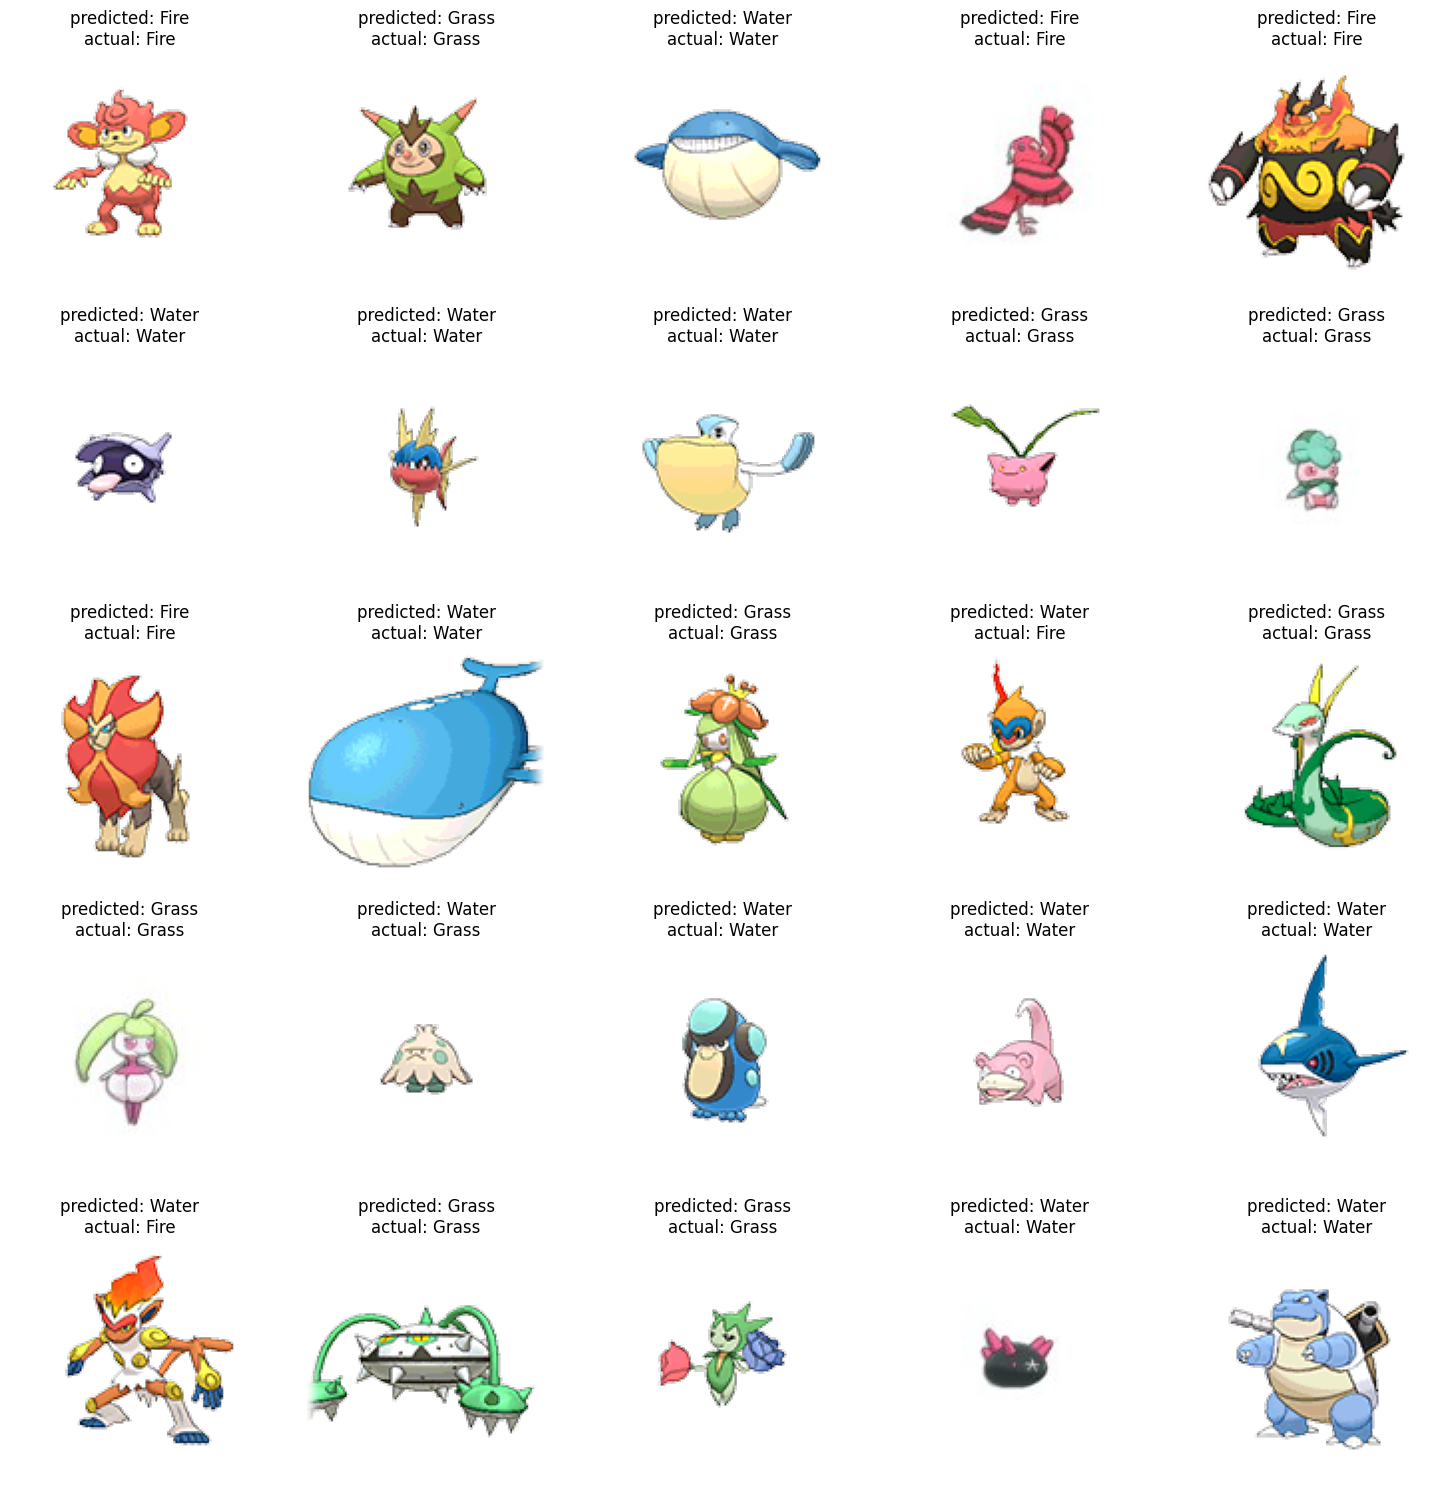

In [25]:
valid_inds = [8, 16, 24, 32, 40]
# valid_inds = [3, 19, 27, 30, 36, 45]
# valid_inds = [28, 196, 224, 232, 240]

# Stick the model on the cpu
_ = model.to("cpu")
_ = model.eval()

# figure, axes = plt.subplots(1, len(valid_inds), figsize=(2 * len(valid_inds), 2))
figure, axes = plt.subplots(5, 5, figsize=(15, 15))

nl = "\n"

# for idx, axis in zip(valid_inds, axes.ravel()):
for idx, axis in enumerate(axes.ravel()):
    img_tensor, target = valid_set[idx]

    with no_grad():
        pred = model(img_tensor.unsqueeze(0)).softmax(dim=1).argmax(dim=1).item()

    axis.imshow(img_tensor.permute(1, 2, 0))
    axis.set_axis_off()
    axis.set_title(
        f"predicted: {target_names[pred]}{nl}actual: {target_names[target.argmax()]}"
    )
plt.tight_layout()